In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import altair as alt
import networkx as nx
import seaborn as sns
import math
import random

Design experiments
0. Make sure graph is connected
1. Duration of the epidemic
2. How many are I and N?
3. P(Infected | Network statistic)
4. I_max = peak time
5. growth rate


Annealed: stationary state
Quenched: number of edges doesn't change, but the configuration changes

In [526]:
n = 100
m = 9
k = 10
pws = 0.2
p_er = 0.2

G1 = nx.erdos_renyi_graph(n, p_er, seed=420)
G2 = nx.watts_strogatz_graph(n, k, pws)
G3 = nx.barabasi_albert_graph(n, m)


def graph_gen(G):
    A = nx.to_numpy_array(G)

    deg = {node:val for (node, val) in G.degree()}
    deg_list = np.array(list(deg.values()))

    triangles = nx.triangles(G)
    tri = list(triangles.values())

    cc_list = np.zeros(len(list(G.nodes())))
    for i in range(1, len(list(G.nodes()))):
        if math.comb(deg_list[i], 2) > 0:
            cc_list[i] = tri[i]/math.comb(deg_list[i], 2)
        else:
            cc_list[i] = 0
    
    return A, deg_list, cc_list
 

In [431]:
def sir_sum(row):
    
    r_vc = row.iloc[3:].value_counts()
    return r_vc

def sir_sum_t(row):
    
    r_vc = row.value_counts()
    return r_vc

In [450]:
st = [random.uniform(0, 1) for elem in range(n)]
state = []
for s in st:
    if s < I_pc:
        state.append(1)
    else: 
        state.append(0)
np.array(state)

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [525]:


def sir_network(G, I_pc, timesteps, mu = 0.1, alpha = 0.05):
    
    '''
    Takes a graph and percentage of infected people in population
    to produce 
    '''
    n = len(G.nodes())
    st = [random.uniform(0, 1) for elem in range(n)]
    state = []
    for s in st:
        if s < I_pc:
            state.append(1)
        else: 
            state.append(0)
    A, deg_list, cc_list = graph_gen(G)

    t = 1
#     timesteps = 100
    df = pd.DataFrame()
    df['degree'] = deg_list
    df['cluster_coeff'] = cc_list
    df['state_0'] = state

    while t <= timesteps:
        new_state = list(np.zeros(n))
        for i in range(n):
            if state[i] == 1:
                if random.uniform(0, 1) < mu:
                    new_state[i] = 2
                else:
                    new_state[i] = 1
            elif state[i] == 0:
                for j in list(G1.neighbors(i)):
                    if (state[j] == 1) & (random.uniform(0, 1) < alpha):
                        new_state[i] = 1
                    else:
                        new_state[i] = 0
            elif state[i] == 2:
                new_state[i] = 2

        col_name = 'state_'+str(t)
        df[col_name] = new_state
        state = new_state
        t += 1
    # return ER
    # df
    SIR = df.apply(lambda row: sir_sum(row), axis = 1)
    SIR = SIR.fillna(0)
    # SIR
    df_prop = df.join(SIR)
    df_prop = df_prop.rename(columns = {0.0:'S_deg', 1.0:'I_deg', 2.0:'R_deg'})
    df_prop = df_prop[['degree', 'cluster_coeff', 'S_deg', 'I_deg', 'R_deg']]
    df_t = df.T[2:]
    SIR = df_t.apply(lambda row: sir_sum_t(row), axis = 1)
    df_time = SIR.fillna(0).reset_index().drop(['index'], axis = 1)
    df_time = df_time.rename(columns = {0.0:'S_time', 1.0:'I_time', 2.0:'R_time'})
    # df_time
    
    return df_prop, df_time



/var/folders/3x/2jygx_494rq5s1llg74g9nhw0000gn/T/ipykernel_39775/4163159004.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = new_state


Text(0, 0.5, 'mean infected people')

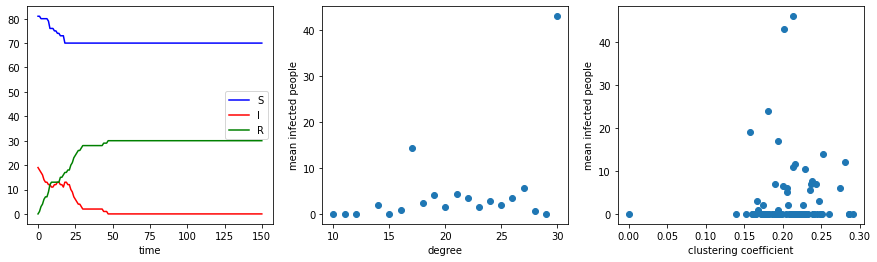

In [527]:
ER_prop, ER_time = sir_network(G1, 0.1, 150)
df_prop = ER_prop.copy()
df_time = ER_time.copy()


d = df_prop[['degree', 'I_deg']].groupby('degree').agg({'I_deg':['mean', 'std']})
d.columns=d.columns.droplevel(0)
d.reset_index(inplace=True)
c = df_prop[['cluster_coeff', 'I_deg']].groupby('cluster_coeff').agg({'I_deg':['mean', 'std']})
c.columns=c.columns.droplevel(0)
c.reset_index(inplace=True)
nrows = 1
ncols = 3
w = 5
h = 4
fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h))
t_ = list(range(500))
ax[0].plot(df_time.S_time, label = 'S', color = 'b')
ax[0].plot(df_time.I_time, label = 'I', color = 'r')
ax[0].plot(df_time.R_time, label = 'R', color = 'g')
ax[0].legend()
ax[0].set_xlabel('time')

ax[1].scatter(d.degree, d[['mean']].values.flatten())
ax[1].set_xlabel('degree')
ax[1].set_ylabel('mean infected people')
ax[2].scatter(c.cluster_coeff, c[['mean']].values.flatten())
ax[2].set_xlabel('clustering coefficient')
ax[2].set_ylabel('mean infected people')


Text(0, 0.5, 'mean infected people')

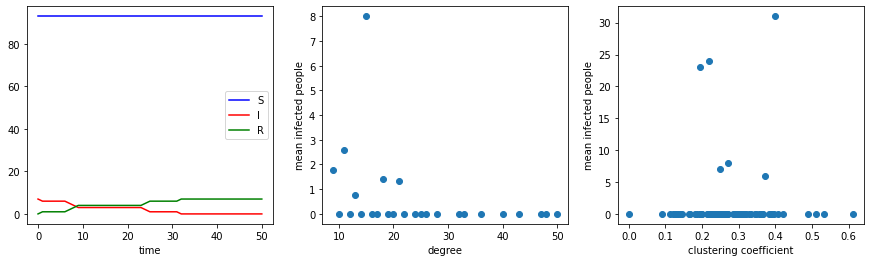

In [529]:
BA_prop, BA_time = sir_network(G3, 0.05, 50)
df_prop = BA_prop.copy()
df_time = BA_time.copy()

nrows = 1
ncols = 3
w = 5
h = 4
d = df_prop[['degree', 'I_deg']].groupby('degree').agg({'I_deg':['mean', 'std']})
d.columns=d.columns.droplevel(0)
d.reset_index(inplace=True)
c = df_prop[['cluster_coeff', 'I_deg']].groupby('cluster_coeff').agg({'I_deg':['mean', 'std']})
c.columns=c.columns.droplevel(0)
c.reset_index(inplace=True)

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h))
t_ = list(range(500))
ax[0].plot(df_time.S_time, label = 'S', color = 'b')
ax[0].plot(df_time.I_time, label = 'I', color = 'r')
ax[0].plot(df_time.R_time, label = 'R', color = 'g')
ax[0].legend()
ax[0].set_xlabel('time')

ax[1].scatter(d.degree, d[['mean']].values.flatten())
ax[1].set_xlabel('degree')
ax[1].set_ylabel('mean infected people')
ax[2].scatter(c.cluster_coeff, c[['mean']].values.flatten())
ax[2].set_xlabel('clustering coefficient')
ax[2].set_ylabel('mean infected people')

Text(0, 0.5, 'mean infected people')

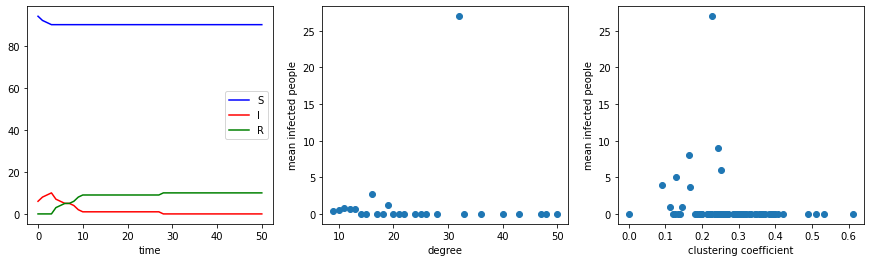

In [530]:
WS_prop, WS_time = sir_network(G3, 0.05, 50)
df_prop = WS_prop.copy()
df_time = WS_time.copy()

nrows = 1
ncols = 3
w = 5
h = 4
d = df_prop[['degree', 'I_deg']].groupby('degree').agg({'I_deg':['mean', 'std']})
d.columns=d.columns.droplevel(0)
d.reset_index(inplace=True)
c = df_prop[['cluster_coeff', 'I_deg']].groupby('cluster_coeff').agg({'I_deg':['mean', 'std']})
c.columns=c.columns.droplevel(0)
c.reset_index(inplace=True)

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h))
t_ = list(range(500))
ax[0].plot(df_time.S_time, label = 'S', color = 'b')
ax[0].plot(df_time.I_time, label = 'I', color = 'r')
ax[0].plot(df_time.R_time, label = 'R', color = 'g')
ax[0].legend()
ax[0].set_xlabel('time')

ax[1].scatter(d.degree, d[['mean']].values.flatten())
ax[1].set_xlabel('degree')
ax[1].set_ylabel('mean infected people')
ax[2].scatter(c.cluster_coeff, c[['mean']].values.flatten())
ax[2].set_xlabel('clustering coefficient')
ax[2].set_ylabel('mean infected people')

BA


Text(0, 0.5, 'R')

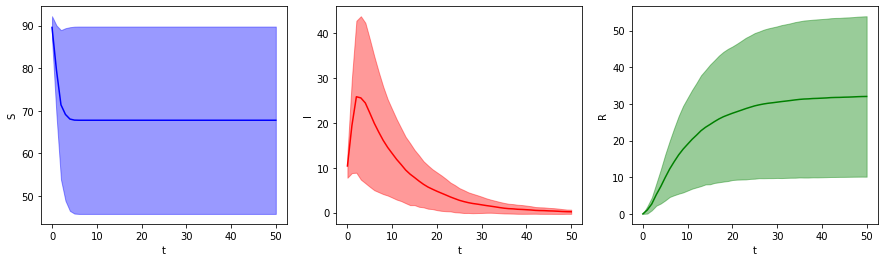

In [512]:
iter_ = 50
t_ = list(range(iter_+1))
g_cnt = 100
prop = pd.DataFrame()
time = pd.DataFrame()
for t in range(g_cnt):
    df_prop, df_time = sir_network(G3, 0.1, iter_)
    p = df_prop[['S_deg', 'I_deg', 'R_deg']]
    p = p.rename(columns = {'S_deg':'S_deg'+str(g_cnt), 'I_deg':'I_deg'+str(g_cnt), 'R_deg':'R_deg'+str(g_cnt)})
    time = pd.concat([time, df_time], axis = 1)
    prop = pd.concat([prop, p], axis = 1)
prop[]    
S_time = time[['S_time']]
I_time = time[['I_time']]
R_time = time[['R_time']]
SIR_time = pd.DataFrame()
SIR_time['S_time_mean'] = S_time.apply(lambda row: row.mean(), axis = 1)
SIR_time['S_time_stdev'] = S_time.apply(lambda row: row.std(), axis = 1)
SIR_time['I_time_mean'] = I_time.apply(lambda row: row.mean(), axis = 1)
SIR_time['I_time_stdev'] = I_time.apply(lambda row: row.std(), axis = 1)
SIR_time['R_time_mean'] = R_time.apply(lambda row: row.mean(), axis = 1)
SIR_time['R_time_stdev'] = R_time.apply(lambda row: row.std(), axis = 1)

nrows = 1
ncols = 3
w = 5
h = 4

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h))
print('BA')
ax[0].plot(t_, SIR_time.S_time_mean, color = 'b')
ax[0].fill_between(t_, SIR_time.S_time_mean - SIR_time.S_time_stdev, SIR_time.S_time_mean + SIR_time.S_time_stdev, color = 'b', alpha = 0.4)
ax[0].set_xlabel('t')
ax[0].set_ylabel('S')

ax[1].plot(t_, SIR_time.I_time_mean, color = 'r')
ax[1].fill_between(t_, SIR_time.I_time_mean - SIR_time.I_time_stdev, SIR_time.I_time_mean + SIR_time.I_time_stdev, color = 'r', alpha = 0.4)
ax[1].set_xlabel('t')
ax[1].set_ylabel('I')

ax[2].plot(t_, SIR_time.R_time_mean, color = 'g')
ax[2].fill_between(t_, SIR_time.R_time_mean - SIR_time.R_time_stdev, SIR_time.R_time_mean + SIR_time.R_time_stdev, color = 'g', alpha = 0.4)
ax[2].set_xlabel('t')
ax[2].set_ylabel('R')

ER


Text(0, 0.5, 'R')

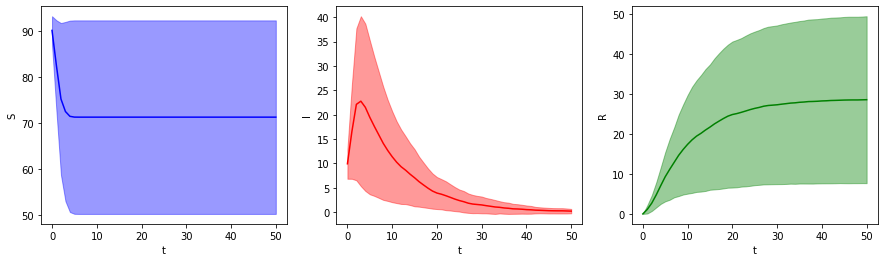

In [506]:
iter_ = 50
t_ = list(range(iter_+1))
g_cnt = 100
prop = pd.DataFrame()
time = pd.DataFrame()
for t in range(g_cnt):
    df_prop, df_time = sir_network(G1, 0.1, iter_)
    p = df_prop[['S_deg', 'I_deg', 'R_deg']]
    time = pd.concat([time, df_time], axis = 1)
    prop = pd.concat([prop, p], axis = 1)
    
S_time = time[['S_time']]
I_time = time[['I_time']]
R_time = time[['R_time']]
SIR_time = pd.DataFrame()
SIR_time['S_time_mean'] = S_time.apply(lambda row: row.mean(), axis = 1)
SIR_time['S_time_stdev'] = S_time.apply(lambda row: row.std(), axis = 1)
SIR_time['I_time_mean'] = I_time.apply(lambda row: row.mean(), axis = 1)
SIR_time['I_time_stdev'] = I_time.apply(lambda row: row.std(), axis = 1)
SIR_time['R_time_mean'] = R_time.apply(lambda row: row.mean(), axis = 1)
SIR_time['R_time_stdev'] = R_time.apply(lambda row: row.std(), axis = 1)

nrows = 1
ncols = 3
w = 5
h = 4

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h))
print('ER')
ax[0].plot(t_, SIR_time.S_time_mean, color = 'b')
ax[0].fill_between(t_, SIR_time.S_time_mean - SIR_time.S_time_stdev, SIR_time.S_time_mean + SIR_time.S_time_stdev, color = 'b', alpha = 0.4)
ax[0].set_xlabel('t')
ax[0].set_ylabel('S')

ax[1].plot(t_, SIR_time.I_time_mean, color = 'r')
ax[1].fill_between(t_, SIR_time.I_time_mean - SIR_time.I_time_stdev, SIR_time.I_time_mean + SIR_time.I_time_stdev, color = 'r', alpha = 0.4)
ax[1].set_xlabel('t')
ax[1].set_ylabel('I')

ax[2].plot(t_, SIR_time.R_time_mean, color = 'g')
ax[2].fill_between(t_, SIR_time.R_time_mean - SIR_time.R_time_stdev, SIR_time.R_time_mean + SIR_time.R_time_stdev, color = 'g', alpha = 0.4)
ax[2].set_xlabel('t')
ax[2].set_ylabel('R')

WS


Text(0, 0.5, 'R')

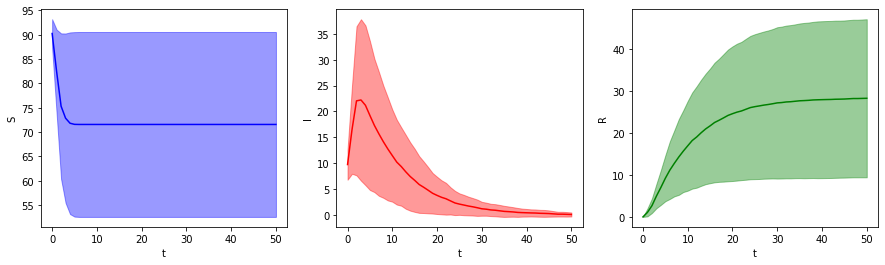

In [507]:
iter_ = 50
t_ = list(range(iter_+1))
g_cnt = 100
prop = pd.DataFrame()
time = pd.DataFrame()
for t in range(g_cnt):
    df_prop, df_time = sir_network(G2, 0.1, iter_)
    p = df_prop[['S_deg', 'I_deg', 'R_deg']]
    time = pd.concat([time, df_time], axis = 1)
    prop = pd.concat([prop, p], axis = 1)
    
S_time = time[['S_time']]
I_time = time[['I_time']]
R_time = time[['R_time']]
SIR_time = pd.DataFrame()
SIR_time['S_time_mean'] = S_time.apply(lambda row: row.mean(), axis = 1)
SIR_time['S_time_stdev'] = S_time.apply(lambda row: row.std(), axis = 1)
SIR_time['I_time_mean'] = I_time.apply(lambda row: row.mean(), axis = 1)
SIR_time['I_time_stdev'] = I_time.apply(lambda row: row.std(), axis = 1)
SIR_time['R_time_mean'] = R_time.apply(lambda row: row.mean(), axis = 1)
SIR_time['R_time_stdev'] = R_time.apply(lambda row: row.std(), axis = 1)

nrows = 1
ncols = 3
w = 5
h = 4

fig, ax = plt.subplots(nrows, ncols, figsize=(ncols*w,nrows*h))
print('WS')
ax[0].plot(t_, SIR_time.S_time_mean, color = 'b')
ax[0].fill_between(t_, SIR_time.S_time_mean - SIR_time.S_time_stdev, SIR_time.S_time_mean + SIR_time.S_time_stdev, color = 'b', alpha = 0.4)
ax[0].set_xlabel('t')
ax[0].set_ylabel('S')

ax[1].plot(t_, SIR_time.I_time_mean, color = 'r')
ax[1].fill_between(t_, SIR_time.I_time_mean - SIR_time.I_time_stdev, SIR_time.I_time_mean + SIR_time.I_time_stdev, color = 'r', alpha = 0.4)
ax[1].set_xlabel('t')
ax[1].set_ylabel('I')

ax[2].plot(t_, SIR_time.R_time_mean, color = 'g')
ax[2].fill_between(t_, SIR_time.R_time_mean - SIR_time.R_time_stdev, SIR_time.R_time_mean + SIR_time.R_time_stdev, color = 'g', alpha = 0.4)
ax[2].set_xlabel('t')
ax[2].set_ylabel('R')

In [4]:
w = np.array([1/12, 1/12, 1/3, 1/6, 1/6, 1/6])
I = np.identity(6)
P = np.array([[0, 0, 1, 0, 0, 0], [0, 0, 1, 0, 0, 0], [1/4, 1/4, 0, 1/4, 1/4, 0], [0, 0, 1/2, 0, 0, 1/2], [0, 0, 1/2, 0, 0, 1/2], [0, 0, 0, 1/2, 1/2, 0]])
W = np.array([w, w, w, w, w, w])
Z = I - P + W
Z

array([[ 1.08333333,  0.08333333, -0.66666667,  0.16666667,  0.16666667,
         0.16666667],
       [ 0.08333333,  1.08333333, -0.66666667,  0.16666667,  0.16666667,
         0.16666667],
       [-0.16666667, -0.16666667,  1.33333333, -0.08333333, -0.08333333,
         0.16666667],
       [ 0.08333333,  0.08333333, -0.16666667,  1.16666667,  0.16666667,
        -0.33333333],
       [ 0.08333333,  0.08333333, -0.16666667,  0.16666667,  1.16666667,
        -0.33333333],
       [ 0.08333333,  0.08333333,  0.33333333, -0.33333333, -0.33333333,
         1.16666667]])

In [5]:
invZ = np.linalg.inv(Z)
invZ

array([[ 1.06944444,  0.06944444,  0.61111111, -0.19444444, -0.19444444,
        -0.36111111],
       [ 0.06944444,  1.06944444,  0.61111111, -0.19444444, -0.19444444,
        -0.36111111],
       [ 0.15277778,  0.15277778,  0.94444444, -0.02777778, -0.02777778,
        -0.19444444],
       [-0.09722222, -0.09722222, -0.05555556,  0.97222222, -0.02777778,
         0.30555556],
       [-0.09722222, -0.09722222, -0.05555556, -0.02777778,  0.97222222,
         0.30555556],
       [-0.18055556, -0.18055556, -0.38888889,  0.30555556,  0.30555556,
         1.13888889]])

In [6]:
(0.9722+0.0972)*6

6.416399999999999